In [1]:
import numpy as np
import pandas as pd
import json
import scipy.stats
import time

from selfoptforest import *

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

In [2]:
ALGOS = ["rf", "lda", "pca"]
ALGO_NAMES = ["RF", "LDA RF", "PCA RF"]

In [3]:
df_benchmark = pd.read_csv("benchmark.csv")
df_benchmark

,openmlid,seed,size,train_time_rf,train_time_lda,train_time_pca,lc_rf_oob,lc_lda_oob,lc_pca_oob,lc_rf_test,lc_lda_test,lc_pca_test
0,3,12,1,0.4893,0.3173,1.2073,0.6287,0.6266,0.6095,0.9136,0.9237,0.8648
1,3,12,2,0.9709,0.4897,2.2059,0.7430,0.7438,0.7288,0.9036,0.9199,0.8861
2,3,12,3,1.4375,0.7608,3.6648,0.8102,0.8023,0.7889,0.9787,0.9512,0.9412
3,3,12,4,1.7601,0.9916,4.8049,0.8644,0.8527,0.8373,0.9725,0.9424,0.9412
4,3,12,5,2.1352,1.4220,6.3777,0.9011,0.8744,0.8602,0.9712,0.9549,0.9574
...,...,...,...,...,...,...,...,...,...,...,...,...
382195,42810,19,196,15720.1380,6027.5009,18431.4143,0.7453,0.6980,0.6333,0.7500,0.6950,0.6050
382196,42810,19,197,15795.7628,6056.6076,18529.1823,0.7460,0.6987,0.6337,0.7480,0.6950,0.6030
382197,42810,19,198,15873.0363,6086.4506,18625.2214,0.7463,0.6993,0.6347,0.7480,0.6960,0.6060
382198,42810,19,199,15953.9179,6117.9070,18716.1674,0.7460,0.6987,0.6340,0.7470,0.6940,0.6040


In [12]:
model_class = "mmf"

  0%|          | 0/96 [00:00<?, ?it/s]

3  (seed 0)
-------------------------------


<IPython.core.display.Javascript object>


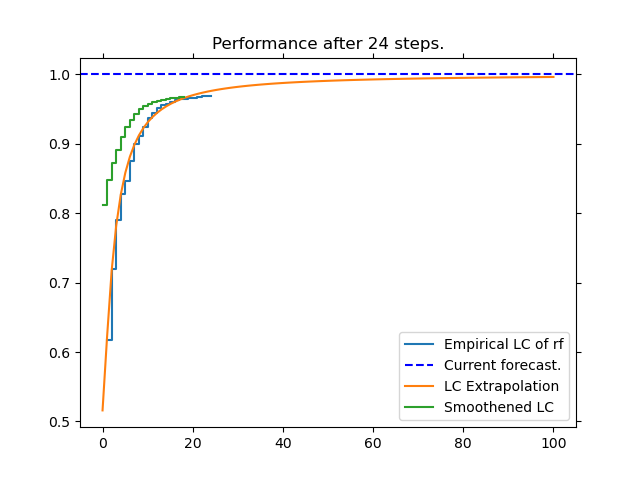

Projecting with model class mmf


KeyboardInterrupt: 

In [14]:
%matplotlib notebook
bm = Benchmark(df_benchmark)


seeds = list(range(20))
datasets = sorted(pd.unique(df_benchmark["openmlid"]))

rows = []

MAX_TREES = 100

for i, openmlid in enumerate(tqdm(datasets)):
    for j, seed in enumerate(seeds):

        print(openmlid, " (seed " + str(seed) + ")\n-------------------------------")
        
        if np.count_nonzero((df_benchmark["openmlid"] == openmlid) & (df_benchmark["seed"] == seed)) == 0:
            print("Skipping, no data for this seed.")
            continue
        
        bm.reset(openmlid, seed)
        rf = SelfOptRF(model_class = model_class)
        rf.simulate_training_with_benchmark(bm, max_forest_size = MAX_TREES, visualize = True )
        
        try:
            choice = rf.choice
            print(f"CHOICE: {choice}")
            print("TRAIN TIME SELF OPT:", bm.get_current_train_time())
            print("TRAIN TIMES PURE RFS: ", [bm.get_train_time(name, MAX_TREES) for name in bm.algos])
            print("WORST CASE TIME: ", sum([bm.get_train_time(name, MAX_TREES) for name in bm.algos]))
            try:
                test_performance = np.round(np.mean([bm.get_test_performance_at_size(choice, MAX_TREES + i) for i in range(-2, 3)]), 4)
            except:
                print("error in retrieving performance, going to next dataset!")
                continue
            print(f"Test performance of choice: {test_performance}")

            best_performance_test = 0
            best_performance_oob = 0
            best_choice_test = None
            best_choice_oob = None
            rf_performance_test = 0
            rf_performance_oob = 0

            row = [openmlid, seed]
            for algo in bm.algos:
                performance_test = np.round(np.mean([bm.get_test_performance_at_size(algo, MAX_TREES + i) for i in range(-2,3)]), 4)
                performance_oob = np.round(np.mean([bm.get_oob_performance_at_size(algo, MAX_TREES + i) for i in range(-2,3)]), 4)
                row.append(performance_oob)
                row.append(performance_test)
                if algo == "rf":
                    rf_performance_test = performance_test
                    rf_performance_oob = performance_oob
                if performance_test > best_performance_test:
                    best_performance_test = performance_test
                    best_choice_test = algo
                if performance_oob > best_performance_oob:
                    best_performance_oob = performance_oob
                    best_choice_oob = algo

                print(algo + "\t" + str(performance_oob), performance_test, np.round(performance_test-  performance_oob, 3))

            gap = best_performance_test - test_performance
            improvement_over_rf = np.round(test_performance - rf_performance_test, 3)
            train_times = [bm.get_current_train_time(a) for a in bm.algos]
            trained_trees = [bm.indices[i] for i, a in enumerate(bm.algos)]
            max_train_times = [bm.get_train_time(a, MAX_TREES) for a in bm.algos]
            time_compression = np.round(sum(train_times) / sum(max_train_times), 2)
            
            print(f"Number of trained trees: {bm.indices}")
            print(f"Actual  Train Times: {train_times}")
            print(f"Maximum Train Times: {max_train_times}")
            print("Time compression:", np.round(time_compression, 2))
            
            # sanity check
            for k in range(3):
                if train_times[k] > max_train_times[k]:
                    raise Exception()

            rows.append(row + [choice, best_choice_oob, best_choice_test, gap, improvement_over_rf] + train_times + max_train_times + trained_trees)
            print("best choice found:", choice == best_choice_oob, choice == best_choice_test, f"Test gap to best: {np.round(gap, 4)}. Test improvement over RF: {improvement_over_rf}")
        except:
            
            print("!!!!!!!!1 DA IST WAS SCHIEFGEGANGEN!!!!!!!!!!")
            raise

In [ ]:
df_comparison = pd.DataFrame(rows, columns=["openmlid", "seed", "rf_oob", "rf_test", "lda_oob", "lda_test", "pca_oob", "pca_test", "choice", "best_choice_oob", "best_choice_test", "gap", "imp", "traintime_rf_act", "traintime_lda_act", "traintime_pca_act", "traintime_rf_max", "traintime_lda_max", "traintime_pca_max", "trees_rf", "trees_lda", "trees_pca"])
gaps_oob = []
gaps_test = []
imps_oob = []
imps_test = []
performance_selfopt_oob = []
performance_selfopt_test = []
for i, row in df_comparison.iterrows():
    gap_oob = row[row["best_choice_oob"] + "_oob"] - row[row["choice"] + "_oob"]
    gap_test = row[row["best_choice_test"] + "_test"] - row[row["choice"] + "_test"]
    imp_oob = row[row["choice"] + "_oob"] - row["rf_oob"]
    imp_test = row[row["choice"] + "_test"] - row["rf_test"]
    gaps_oob.append(gap_oob)
    gaps_test.append(gap_test)
    imps_oob.append(imp_oob)
    imps_test.append(imp_test)
    performance_selfopt_oob.append(row[row["choice"] + "_oob"])
    performance_selfopt_test.append(row[row["choice"] + "_test"])
df_comparison["selfopt_oob"] = performance_selfopt_oob
df_comparison["selfopt_test"] = performance_selfopt_test
df_comparison["gap_oob"] = gaps_oob
df_comparison["gap_test"] = gaps_test
df_comparison["imp_oob"] = imps_oob
df_comparison["imp_test"] = imps_test
df_comparison["traintime_total_act"] = df_comparison["traintime_rf_act"] + df_comparison["traintime_lda_act"] + df_comparison["traintime_pca_act"]
df_comparison["traintime_total_max"] = df_comparison["traintime_rf_max"] + df_comparison["traintime_lda_max"] + df_comparison["traintime_pca_max"]
df_comparison["time_compression"] = df_comparison["traintime_total_act"] / df_comparison["traintime_total_max"]
df_comparison["tree_compression"] = (df_comparison["trees_rf"] + df_comparison["trees_lda"] + df_comparison["trees_pca"]) / 300
df_comparison.to_csv("comparison-" +  model_class + ".csv", index=False)
df_comparison